Using TensorFlow backend.


(1651, 228, 1)
(1238, 228, 1)


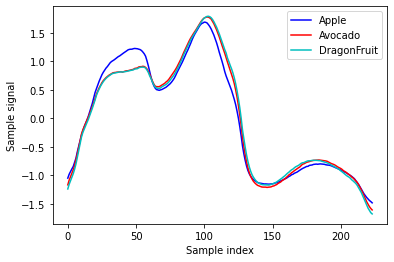

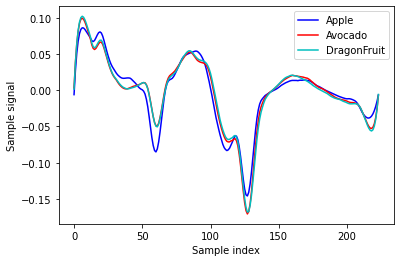

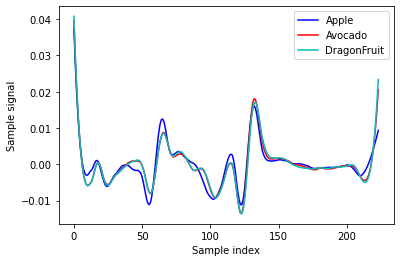

In [2]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPool1D, Dropout, Flatten, Dense,Input
from keras.models import Model
from keras import optimizers
import cv2
from scipy import signal
import matplotlib.pyplot as plt

def smooth1(x):
  X_new=x.reshape(228,)
  y=signal.savgol_filter(X_new,window_length=25, polyorder=5,deriv=1)
  y=np.expand_dims(y,1)
  y=np.asarray(y)
  return y
def smooth2(x):
  X_new=x.reshape(228,)
  y=signal.savgol_filter(X_new,window_length=25, polyorder=5,deriv=2)
  y=np.expand_dims(y,1)
  y=np.asarray(y)
  return y
def standardd(X):
	Xnew=np.asarray(X,dtype='float')
	total=0
	u=X.sum()/len(X)
	for i in range(len(X)):
		total+=((X[i]-u)**2)
	o=math.sqrt(total/len(X))
	for i in range(len(X)):
		Xnew[i]=float((X[i]-u)/o)
	return Xnew
def processdata(X_data):
  X_f=[]
  for i in range(X_data.shape[0]):
    X_data[i]=standardd(X_data[i])
    xtem=X_data[i].reshape(228,)
    X_f.append(cv2.resize(xtem,(1,224)))
  X_f=np.asarray(X_f)
  return X_f
def processdata1(X_data):
  for i in range(X_data.shape[0]):
    X_data[i]=standardd(X_data[i])
  X_f=[]
  X_tem=np.asarray(list(map(lambda e: smooth1(e),X_data)))
  for i in range(X_tem.shape[0]):
    xtem=X_tem[i].reshape(228,)
    X_f.append(cv2.resize(xtem,(1,224)))
  X_f=np.asarray(X_f)
  return X_f
def processdata2(X_data):
  X_f=[]
  for i in range(X_data.shape[0]):
    X_data[i]=standardd(X_data[i])
  X_tem=np.asarray(list(map(lambda e: smooth2(e),X_data)))
  for i in range(X_tem.shape[0]):
    xtem=X_tem[i].reshape(228,)
    X_f.append(cv2.resize(xtem,(1,224)))
  X_f=np.asarray(X_f)
  return X_f

training=np.load('./Data/Training data/trainingeng1.npz')
X_data=training['xdata']
y_true=training['ytrue']
y_onehot = np.zeros((len(y_true), 5))
y_onehot[np.arange(len(y_true)), y_true] = 1
X_train, X_test, y_train, y_test = train_test_split(X_data, y_onehot)


X_train0=processdata(X_train)
plt.plot(X_train0[0],'b',label="Apple")
plt.plot(X_train0[99],'r',label="Avocado")
plt.plot(X_train0[150],'c',label="DragonFruit")
plt.xlabel('Sample index')
plt.ylabel('Sample signal')
plt.legend()
plt.show()

X_train1=processdata1(X_train)
plt.plot(X_train1[0],'b',label="Apple")
plt.plot(X_train1[99],'r',label="Avocado")
plt.plot(X_train1[150],'c',label="DragonFruit")
plt.xlabel('Sample index')
plt.ylabel('Sample signal')
plt.legend()
plt.show()

X_train2=processdata2(X_train)
plt.plot(X_train2[0],'b',label="Apple")
plt.plot(X_train2[99],'r',label="Avocado")
plt.plot(X_train2[150],'c',label="DragonFruit")
plt.xlabel('Sample index')
plt.ylabel('Sample signal')
plt.legend()
plt.show()

In [3]:
X_test0=processdata(X_test)
X_test1=processdata1(X_test)
X_test2=processdata2(X_test)

In [4]:
from keras.layers import merge
from keras.callbacks import *
#first layer
input_shape=(224,1)
model1=Input(input_shape)
print(model1[0])
print(model1.shape)
conv1=Conv1D(16,2,activation='relu')(model1)
maxp1=MaxPool1D(2)(conv1)
conv2=Conv1D(32,2,activation='relu')(maxp1)
maxp2=MaxPool1D(2)(conv2)
conv3=Conv1D(32,2,activation='relu')(maxp2)
maxp3=MaxPool1D(2)(conv3)
conv4=Conv1D(64,2,activation='relu')(maxp3)
maxp4=MaxPool1D(2)(conv4)
flat1=Flatten()(maxp4)
#second layer
input_shape2=(224,1)
model2=Input(input_shape2)
conv12=Conv1D(16,2,activation='relu')(model2)
maxp12=MaxPool1D(2)(conv12)
conv22=Conv1D(32,2,activation='relu')(maxp12)
maxp22=MaxPool1D(2)(conv22)
conv32=Conv1D(32,2,activation='relu')(maxp22)
maxp32=MaxPool1D(2)(conv32)
conv42=Conv1D(64,2,activation='relu')(maxp32)
maxp42=MaxPool1D(2)(conv42)
flat2=Flatten()(maxp42)
#third layer
input_shape3=(224,1)
model3=Input(input_shape3)
conv13=Conv1D(16,2,activation='relu')(model3)
maxp13=MaxPool1D(2)(conv13)
conv23=Conv1D(32,2,activation='relu')(maxp13)
maxp23=MaxPool1D(2)(conv23)
conv33=Conv1D(32,2,activation='relu')(maxp23)
maxp33=MaxPool1D(2)(conv33)
conv43=Conv1D(64,2,activation='relu')(maxp33)
maxp43=MaxPool1D(2)(conv43)
flat3=Flatten()(maxp43)




#merge layers
merge=merge.concatenate([flat1,flat2,flat3])
dense1=Dense(128,activation='relu')(merge)
output=Dense(5,activation='softmax')(dense1)


model=Model(inputs=[model1,model2,model3],outputs=output)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=0.0001, verbose = 1)
early_stop = callbacks.EarlyStopping('val_loss', patience=250, verbose=1, restore_best_weights=True)

adam = optimizers.Adam(0.0001, 0.9, 0.99)
model.compile(adam, 'categorical_crossentropy', ['accuracy'])
model.summary()
history = model.fit([X_train0,X_train1,X_train2], y_train, 64, 1200,1,[early_stop,reduce_lr],validation_data=([X_test0,X_test1,X_test2],y_test))

Tensor("strided_slice:0", shape=(224, 1), dtype=float32)
(None, 224, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 1)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 223, 16)      48          input_1[0][0]                    
____________________